Wiki Loves Africa Power Analysis
Trial written by Julia Kamin for tutoriat with John-Henry and Max

In [79]:
# LOAD LIBRARIES
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)
library(ggplot2)
library(rlang)
library(gmodels)
library(tidyverse)
library(viridis)
library(fabricatr)
library(estimatr)
library(DeclareDesign)
library(blockTools)
library(beepr)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))

library(survminer)
library(survival)
## ^^ documentation: https://cran.r-project.org/web/packages/survminer/vignettes/Informative_Survival_Plots.html

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] survival_2.43-3      survminer_0.4.3      ggpubr_0.2          
 [4] magrittr_1.5         beepr_1.3            blockTools_0.6-3    
 [7] DeclareDesign_0.12.0 randomizr_0.16.1     estimatr_0.14       
[10] fabricatr_0.6.0      viridis_0.5.1        viridisLite_0.3.0   
[13] forcats_0.3.0        str

In [2]:
data.path <- "/home/civilservant/Tresors/CivilServant/projects/wikipedia-integration/wikipedia-loves-africa/pre-pipeline-2018-analysis"
wla.df <- read.csv(file.path(data.path, "power-analysis-2016-vs-2017.csv"))

In [101]:
summary(wla.df)

   img_actor       total_transfers_2016_and_earlier
 Min.   :     13   Min.   :      2                 
 1st Qu.:4344960   1st Qu.:   1086                 
 Median :4465896   Median :   2726                 
 Mean   :4752278   Mean   :  35661                 
 3rd Qu.:5500333   3rd Qu.:  10457                 
 Max.   :6460352   Max.   :4595341                 
                                                   
 images_contributed_2016_and_earlier total_transfers_2017
 Min.   :   1.0                      Min.   :  140       
 1st Qu.:   1.0                      1st Qu.: 2052       
 Median :   2.0                      Median : 4825       
 Mean   :   7.4                      Mean   : 9734       
 3rd Qu.:   5.0                      3rd Qu.:14014       
 Max.   :1113.0                      Max.   :82605       
                                     NA's   :1674        
 images_contributed_2017 first_time   didnt_return   return    
 Min.   :  1.0           False:1736   False:  62   False

In [102]:
## remove first timers
wla.df <- subset(wla.df, first_time == "False")

In [103]:
# make return binary
wla.df$return.int <- ifelse(wla.df$return == "True",1,0)

In [104]:
mean(wla.df$return.int)

[1] 0.03571

In [105]:
sd(wla.df$return.int)

[1] 0.1856

In [106]:
N = 100
mean.part = mean(wla.df$return.int)
population <- 
  declare_population(N = N,
                     return.participate = rbinom(n = N, 1, mean.part)) 


df1 <- population()

summary(df1)

      ID            return.participate
 Length:100         Min.   :0.00      
 Class :character   1st Qu.:0.00      
 Mode  :character   Median :0.00      
                    Mean   :0.06      
                    3rd Qu.:0.00      
                    Max.   :1.00      

In [65]:
return.participate = df1$return.participate
summary(return.participate)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00    0.05    0.00    1.00 

In [107]:
potential_outcomes <- declare_potential_outcomes(Y_Z_0 = return.participate, # the control group, here we expect business as usual 
                                                 Y_Z_1 = return.participate + 
                                                     ifelse(return.participate == 0, rbinom(100, 1, ate),0)) # the treatment group, business as usual + the productivity boost from coffee
                                                 

df1 <- potential_outcomes(df1)

df1[1:10,]

ID,return.participate,Y_Z_0,Y_Z_1
001,0,0,0
002,0,0,0
003,0,0,0
004,0,0,0
005,0,0,0
006,1,1,1
007,1,1,1
008,0,0,0
009,0,0,0
010,0,0,0


In [108]:
assignment <- declare_assignment(prob = .5, 
                                 assignment_variable = Z) # by the relevant part of columns to assign from, default assignment_variable = Z
df1 <- assignment(df1)
df1[1:10,]

ID,return.participate,Y_Z_0,Y_Z_1,Z,Z_cond_prob
001,0,0,0,0,0.5
002,0,0,0,0,0.5
003,0,0,0,0,0.5
004,0,0,0,1,0.5
005,0,0,0,1,0.5
006,1,1,1,1,0.5
007,1,1,1,0,0.5
008,0,0,0,0,0.5
009,0,0,0,0,0.5
010,0,0,0,1,0.5


In [109]:
reveal <- declare_reveal(outcome_variables = Y) # here we use the prefix before the Z part begins, in our case this is simply Y

df1 <- reveal(df1)

df1[1:20,]

ID,return.participate,Y_Z_0,Y_Z_1,Z,Z_cond_prob,Y
001,0,0,0,0,0.5,0
002,0,0,0,0,0.5,0
003,0,0,0,0,0.5,0
004,0,0,0,1,0.5,0
005,0,0,0,1,0.5,0
006,1,1,1,1,0.5,1
007,1,1,1,0,0.5,1
008,0,0,0,0,0.5,0
009,0,0,0,0,0.5,0
010,0,0,0,1,0.5,0


In [110]:
estimand <- declare_estimand(ATE = mean(Y_Z_1 - Y_Z_0))

In [116]:
estimated_effect <- declare_estimator(
  Y ~ Z,
  model = lm_robust,
  estimand = c("ATE"), # also just `estimand` (the object we defined above) would work
  #subset = R == 1, # only keep people not lost to attrition
  label = "Treatment Effect"
)

In [117]:
design <- population  + 
              potential_outcomes + 
              estimand + 
              assignment + 
              reveal + 
              estimated_effect 

In [118]:
diagnose.experiment  <- function( n.size, cdf, sims.count = 500, bootstrap.sims.count = 500){
    design <- population +
              potential_outcomes +       + 
              estimand + 
              assignment + 
              reveal + 
              estimated_effect 
    
    diagnosis <- diagnose_design(design, sims = sims.count, 
                                 bootstrap_sims = bootstrap.sims.count)
    diagnosis
}

In [119]:
# i'm pretty sure this is where i go off the rails
pa.config <- data.frame(
    pa.label = "wla.experiment",
    n.max = 6000,
    n.min = 1000,
    
    part.current <- mean.part,
    part.treat  <- mean.part + 0.035
    
)

In [81]:
source.path <- "~/CivilServant-Wikipedia-Analysis/power-analysis"
source(file.path(source.path, "power-analysis-utils.R"))

In [ ]:
interval = 1000
power.iterate.df <- iterate.for.power(pa.config, 
                                      diagnosis.method=diagnose.experiment, 
                                      iteration.interval = interval)

Warning message:
“Removed 6 rows containing missing values (geom_path).”Warning message:
“Removed 6 rows containing missing values (geom_point).”

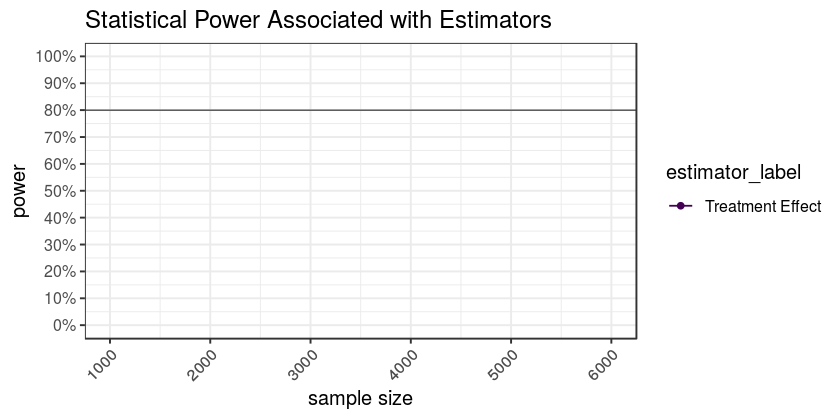

In [83]:
ggplot(power.iterate.df, aes(n, power, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    geom_hline(yintercept=0.8, size=0.25) +
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_x_continuous(breaks = seq(pa.config$n.min,pa.config$n.max,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Statistical Power Associated with Estimators")